# Home 4: Build a CNN for image recognition.

### Name: Allison Aprile


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [18]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [19]:
def to_one_hot(y, num_class=10):
    # Initialize matrix of zeros - shape (n x 10)
    one_hot = numpy.zeros((len(y), num_class))

    # Change element to 1 where second dimension corresponds to label
    for i, label in enumerate(y):
        one_hot[i, label] = 1.
    
    return one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [20]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

<font color='navy'>Of all the architectures discussed in class, VGG16 is the most feasible to implement for this assignment. It is not as deep as Inception or ResNet (and therefore, won't require as much training time), but still had fair performance in the ImageNet competition. 

<font color='navy'>The classic VGG16 architecture includes 13 convolutional blocks and 2 fully-connected layers. I will eliminate/add layers and batch normalization/dropout as needed.

In [38]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.models import Sequential

'''
Basing network loosely off of VGG architecture 
'''
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3))) # Convolutional layer
model.add(BatchNormalization()) # Batch normalization (for feature scaling hidden layers)
model.add(Activation('relu')) # Activation function

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))

model.add(MaxPooling2D((2, 2))) # Pooling layer

# Repeat blocks with increasing filter sizes
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))

model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))

model.add(MaxPooling2D((2,2)))

# Flatten vector for input into Dense layers
model.add(Flatten())

# Add 0.5 Dropout for regularization
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_27 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 64)       

<font color='navy'>After fitting the model with different combinations of learning rates and optimizers, I decided on a 0.001 learning rate and SGD optimizer. Because this part is only trained on a subset of the data, I ran it for 50 epochs to evaluate any points of overfitting and to get a fair idea of how the architecture would affect the validation performance.

In [25]:
from keras import optimizers

learning_rate = 1E-3 # to be tuned! (1E-4 gave similar performance)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate),    # Changed to SGD optimizer because seemed to train better
              metrics=['acc'])

In [26]:
# Train model - updated to 50 epochs
history = model.fit(x_tr, y_tr, batch_size=32, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
1250/1250 [==============================] - 308s 246ms/step - loss: 2.2185 - acc: 0.2036 - val_loss: 1.6642 - val_acc: 0.3986
Epoch 2/50
1250/1250 [==============================] - 305s 244ms/step - loss: 1.7247 - acc: 0.3580 - val_loss: 1.5150 - val_acc: 0.4507
Epoch 3/50
1250/1250 [==============================] - 303s 242ms/step - loss: 1.5565 - acc: 0.4291 - val_loss: 1.4155 - val_acc: 0.4829
Epoch 4/50
1250/1250 [==============================] - 302s 242ms/step - loss: 1.4644 - acc: 0.4670 - val_loss: 1.3919 - val_acc: 0.4954
Epoch 5/50
1250/1250 [==============================] - 306s 245ms/step - loss: 1.3936 - acc: 0.4915 - val_loss: 1.3138 - val_acc: 0.5276
Epoch 6/50
1250/1250 [==============================] - 303s 242ms/step - loss: 1.3155 - acc: 0.5219 - val_loss: 1.3005 - val_acc: 0.5340
Epoch 7/50
1250/1250 [==============================] - 301s 241ms/step - loss: 1.2586 - acc: 0.5453 - val_loss: 1.1922 - val_acc: 0.5731
Epoch 8/50
1250/1250 [============

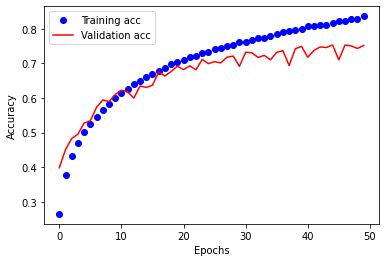

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Save model
model.save('Users/aaprile/Desktop/partial_trained_model')

INFO:tensorflow:Assets written to: Users/aaprile/Desktop/partial_trained_model/assets


## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

<font color='navy'>This time, I trained the model for only 10 epochs and added a momentum to the optimizer. Although it could have continued for a few more epochs, without the validation set I decided to stop once it hit a loss close to the minimum in the above to avoid overfitting.

In [39]:
# Recompile model, add momentum to optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),    
              metrics=['acc'])

In [40]:
# Train model on entire training set (50K samples)
history = model.fit(x_train, y_train_vec, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 358s 228ms/step - loss: 1.8028 - acc: 0.3429
Epoch 2/10
1563/1563 [==============================] - 356s 228ms/step - loss: 1.2242 - acc: 0.5578
Epoch 3/10
1563/1563 [==============================] - 355s 227ms/step - loss: 1.0057 - acc: 0.6421
Epoch 4/10
1563/1563 [==============================] - 353s 226ms/step - loss: 0.8574 - acc: 0.6949
Epoch 5/10
1563/1563 [==============================] - 359s 229ms/step - loss: 0.7680 - acc: 0.7272
Epoch 6/10
1563/1563 [==============================] - 359s 230ms/step - loss: 0.7045 - acc: 0.7526
Epoch 7/10
1563/1563 [==============================] - 357s 229ms/step - loss: 0.6440 - acc: 0.7726
Epoch 8/10
1563/1563 [==============================] - 353s 226ms/step - loss: 0.5914 - acc: 0.7894
Epoch 9/10
1563/1563 [==============================] - 347s 222ms/step - loss: 0.5436 - acc: 0.8064
Epoch 10/10
1563/1563 [==============================] - 354s 227ms/step - loss: 0.5165 - a

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [41]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 17s 53ms/step - loss: 0.6402 - acc: 0.7835
loss = 0.6402202844619751
accuracy = 0.7835000157356262
